In [15]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt 

B = 3 # upper bounds, assuming lower bounds is 0
k = 1 # linear coeffient between drift rate and coherence
coh = 0.064 # choose one coefficient
driftRate = k * coh # drift rate
sigma = 1
deltaT = 0.1
ndt = 0.1
a = 0.55

nTrial = 3000
RT = np.zeros(nTrial)
corrects = np.zeros(nTrial)

for j in range(nTrial):
    i = 0
    evidence = a*B
    accumEvidence = []
    accumEvidence.append(evidence)
    while True:
        # update frame number
        i = i+1
        # update evidence
        # for every frame, we sample a 
        evidence = evidence + norm.rvs(loc=0, scale=sigma, size=1)[0] * np.sqrt(deltaT) + driftRate*deltaT 
        
        accumEvidence.append(evidence)
        if (evidence) > B:
            correct = 1
            break
        elif (evidence) < 0:
            correct = 0
            break

    RT[j]=len(accumEvidence)*deltaT+ndt
    corrects[j] = correct
    
data = np.zeros((3000, 3))  # Create an empty array of shape (3000, 3)
data[:, 0] = np.repeat(coh, 3000)  # Repeat each element of coh 600 times to match the size of data
data[:, 1] = RT
data[:, 2] = corrects

np.savetxt('test2.txt', data, delimiter='\t')
    

In [16]:
import numpy as np 
from scipy.special import softmax 
from scipy.stats import bernoulli, norm, uniform
import time 
from scipy.optimize import minimize
from ddm import ddmpdf, pdf # ddm probility density function

from IPython.display import clear_output
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt 
import seaborn as sns 

import sys 
sys.path.append("..") 
from utils.env import frozen_lake
from utils.viz import viz 
viz.get_style()

In [17]:

# load  data
data = np.loadtxt('test2.txt')
nTrial = data.shape[0] # how many trials
eps = np.finfo(float).eps

In [18]:
# define a negative log-likelihood objective functions
def loglikeli(k, data):
    '''
    <params>:(4,) array, drift coefficient, decision boundary, initial bias, non-decision time
    '''
    B = 2 # decision boundary
    a = 0.5# initial bias (0, 1)
    ndt = 0.1 # non-decision time
    nTrial = data.shape[0] # how many trials
    pp = np.empty(nTrial)
    for i in range(nTrial): # loop trial
        pp[i] = ddmpdf(k, a, B, ndt, coh=data[i, 0], rt=data[i, 1], correct=data[i, 2])

    pp_valid = 0.99*pp+eps  # Set a small positive threshold for invalid probabilities
    return np.log(pp_valid).sum() # take log, sum，add negative

In [19]:
#proposal dist 为gamma分布.使得drift coefficient始终大于零
def metropolis_hastings(data, y_k, n_sample=3000, n_burnin=1000, random_seed=1234):
    np.random.seed(random_seed)
    samples = []
    init_k = y_k  # 初始化你要估计的参数

    for i in range(n_sample + n_burnin):
        # 从提议分布中采样
        pro_k = np.exp(norm(loc=init_k,).rvs())
        # 由于k始终大于零，所以需要进行指数函数的转换
        
        # 计算对数似然
        loglik_proposed = loglikeli(pro_k, data)
        loglik_init = loglikeli(init_k, data)
        
        # 计算接受率
        a_log = np.min([0, (loglik_proposed-loglik_init)])
        # 接受或拒绝 
        u_log = np.log(uniform.rvs(0,1))
        if u_log < a_log:
            samples.append(pro_k)   # 接受并跳转到新的sample
            init_k = pro_k
        else:samples.append(init_k) # 保留原来那个sample不变
    return samples

# 设置初始参数值
y_k = 0.1

# 调用 Metropolis-Hastings 算法
samples = metropolis_hastings(data, y_k)


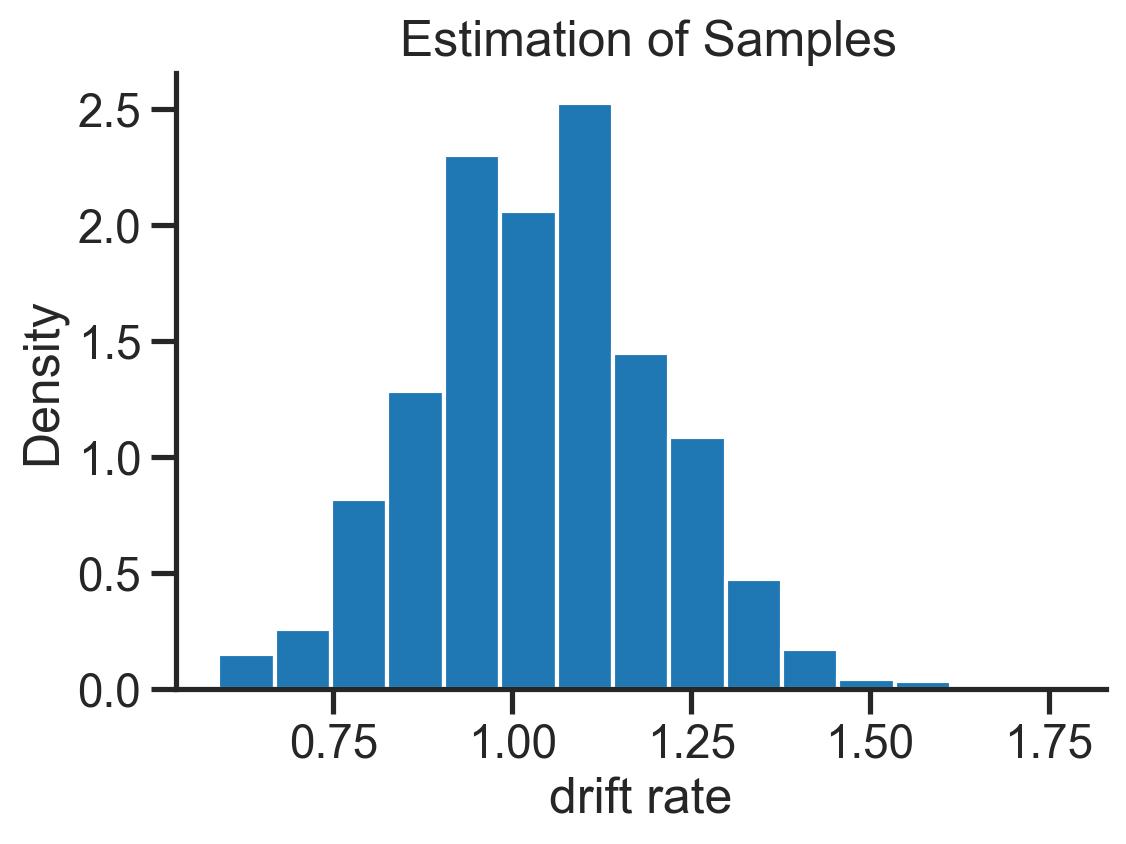

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize = (6,4))
plt.hist(samples, bins=15, density=True, label='samples')
plt.xlabel('drift rate')
plt.ylabel('Density')
plt.title(' Estimation of Samples')
plt.savefig('MH.png')
plt.show()
